In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib
%matplotlib inline
from pprint import pprint

df = pd.read_excel('SSDSE-E-2023.xlsx', header=[0, 2], index_col=[0,1])
df.index.names=['地域コード','都道府県']
df.columns.names=['項目コード','項目名']
df.head()

## 「プチ」勉強会 20230617
* ペアプロ用に作成した問題から。
* PandasのMultiIndexを使っているが、実は今回は「リスト内包表記」と「インデックス参照」と「スライス」がテーマ。


### 今回取り組んでみたもの

1. MultiIndexは少し扱いにくいところがあるのでそこを少し便利にする関数を作成し、改善していくストーリー。<br>
   まず、最初にお断りしておかなければならないこと。<br>
   それは、Pandasの範囲参照はMultIndexでも、以下のようにlevel0のコードを使ってスライス指定で範囲抽出できるということ。<br>

In [ ]:
df.loc['R10000':'R15000', 'A1101':'A5101']

2. 但し、これがインデックスやカラムの参照だと、そのまま文字列のコードではエラーになってしまう。

In [ ]:
df.index['R10000':'R15000']

3. 引数がintならOK

In [ ]:
df.index[10:15]

4. 今回の課題では、例えばこれを「文字列でもスライス指定できるような関数を作ってみよう」というもの。<br>
   ちなみに、カラムの項目コードについていえば、先頭のアルファベットがジャンルを表していて、その下の数字も桁数毎に分類コードになっているので、<br>
   「先頭文字列でジャンル毎に抽出する」なんてこともやってみたい。<br>
   ほか、地域コードは基本的に一意の都道府県コードなので、'R10000'まで全部打たなくても'R10'だけでも受け付けるようにしたい。

5. で、いきなりスライスだと途方に暮れるので、少しずつ機能を追加していく。あとで使うので一応関数にしている。<br>
   まずは、単体の地域コードでインデックスをリストで抽出する。<br>
   なんでリストに変換しているかは後ほど明らかになる。

In [ ]:
def pref_listβ(*keys, data=df):
    prefs = []
    for key in keys:
        prefs += [i for i in data.index if i[0] == key]
    return prefs

pprint(pref_listβ('R13000', 'R14000', 'R15000', 'R16000', 'R17000'))

6. 「いきなり何？」と思うひとがいるかもしれないが、心配ありません。これから説明します。<br>
    複数の引数をとって何回も処理させているからfor文を使っているが、ミソはこの部分。
```
    prefs = [i for i in data.index if i[0] == key]
```

7. if文を除けばこう。つまり、インデックスのリストを丸っと抽出しているだけ。
```
    prefs = [i for i in data.index]
```

In [ ]:
data = df
prefs = [i for i in data.index]
prefs

8. そこにこのif文を付けている。<br>
つまり、i[0]はMultiIndexの要素のtuple、例えば（'R13000', '東京都'）だったらi[0]は'R13000'を参照している。<br>
それがkeyと一致する条件ということ。
回りくどいようだが、'R13000'を（'R13000', '東京都'）に変換しているということだ。<br>
それを引数分、回して表示している。「なーんだ」という話。
```
    if i[0] == key
```

In [ ]:
key = ('R13000', '東京都')
key[0]


In [ ]:
def pref_listβ(*keys, data=df):
    prefs = []
    for key in keys:
        prefs += [i for i in data.index if i[0] == key]
    return prefs

pprint(pref_listβ('R13000', 'R14000', 'R15000', 'R16000', 'R17000', 'R18000'))

9. ちなみに、for文で回数回すので、prefsは予め空リストを作成しておいて、そこに追加する表記にしている。<br>
   あと、引数keysは*keysにして、つまり、「可変長引数」にして、何個でも受け付けられるようにしている。
```
    prefs +=
    *keys
```

10. それから、そもそもの話、level0の要素からlvel1も含めたタプルを取得する方法は２通り考えられる。<br>
    * ひとつは位置を取得して再び参照する直感的なやり方。<br>
    * そしてもうひとつは、今回のように全体からlevel0だけ部分一致するものを抽出するやり方。<br>
    
    どちらも可能だが、実際書いてみて、今回のケースは「リスト内包表記」の分かりやすさの勝ち！と思う。<br>
    この後のことも含めればこの方法しかないことも分かるだろう。

    次は、項目コードを先頭文字列でジャンル毎に抽出するやつを書く。これだ。

In [ ]:
def item_list(*keys, data=df):
    items = []
    for key in keys:
        items += [i for i in data.columns if i[0][0:len(key)] == key]
    return items

pprint(item_list('A13', 'E'))

11. 「なーんだ、さっきとほとんど同じじゃないか」と思った貴方！そうなんです。違うのは以下の部分だけです。<br>
    比べてみてください。参照部分がちょっと複雑になっているのが分かります。<br>
    実際に値を入れて確かめてみましょう。
```
    if i[0] == key
    if i[0][0:len(key)] == key
```

12. 引数の文字の長さをlen(key)で取得して、'R13000'をさらにインデックス参照して長さ分の文字列を取得しているのが分かります。<br>
    このようにインデックス参照というのはネストしても構わないんです。

In [ ]:

i = ('R13000','東京都')
key1 = 'R13'
key2 = 'R130'

print(len(key1))
print(len(key2))

print(i[0][0:len(key1)])
print(i[0][0:len(key2)])


13. でもって再掲。もう分かりますね。

In [ ]:
def item_list(*keys, data=df):
    items = []
    for key in keys:
        items += [i for i in data.columns if i[0][0:len(key)] == key]
    return items

pprint(item_list('A13', 'E'))

14. さて、いよいよスライスしてみましょうか。まずはこれです。

In [ ]:
def pref_sliceβ(start, stop, step=1, data=df):
    a, b = data.index.slice_locs(start, stop)
    prefs = data.index[a:b:step]
    return list(prefs)

pprint(pref_sliceβ('R13000', 'R23000'))

15. 「うわっ。なんかちょっと違う・・・。それに良くわからないメソッド使ってるし・・・。」と思った貴方！正解です。<br>
    実は私もslice_locsなんて知りませんでした。最初はこんな風にget_loc使ってました。昨日、こちらに乗り換えました・・・。
```
    a = data.index.get_loc(start)
    b = data.index.get_loc(stop)
```

16. ちなみに、このMultiIndexにおけるget_locの挙動・・・面白いんです！

In [ ]:
a = df.index.get_loc('R13000')
a

17. 「ちょっと意外～！」と思いませんか？スライス？ナニコレです。<br>
    そう、get_locの返り値はintだけじゃないんです。sliceもあれば真偽値もある。<br>
    興味のあるひとは是非、公式みてみて！

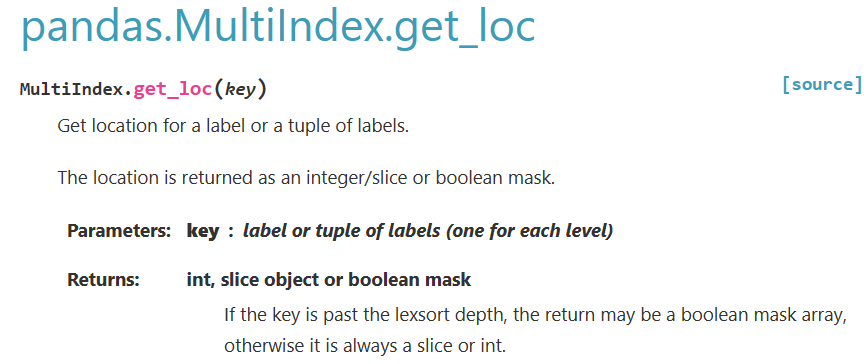

18. それから、sliceだけど、スコープを確認してみると特殊メソッド除きでこんな感じ。<br>
    indicesって何？と思ったひとは、これも調べてみてみて！<br>
    それにしても「リスト内包表記」って便利！

In [ ]:
[d for d in dir(slice) if not'__' in d]


19. 取り敢えず、今必要なのはカラムの位置だから、startということが分かる。

In [ ]:
print(a.indices)
print(a.start)
print(a.step)
print(a.stop)

20. だから、最初はこんな風に書いていた。もちろん、結果は同じ。

In [ ]:
def pref_sliceβ(start, stop, step=1, data=df):
    a = data.index.get_loc(start)
    b = data.index.get_loc(stop)
    a = a.start
    b = b.start
    prefs = data.index[a:b:step]
    return list(prefs)

pprint(pref_sliceβ('R13000', 'R23000'))

21. でも、Multiindex.get_locの公式眺めていたら、slice_locsというメソッドがこそっと書かれている<br>
    で、こうなった。「slice_locsってどんなだ？」と思ったひとは公式へGO！<br>
    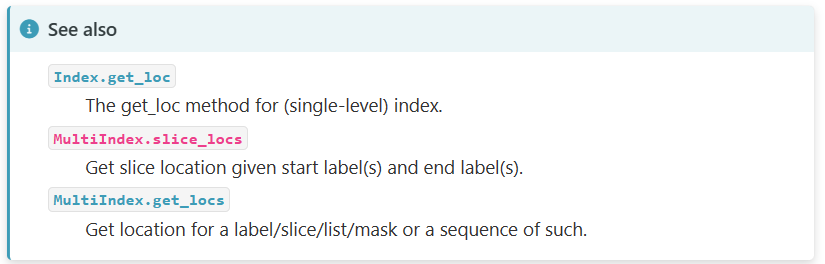

In [ ]:
def pref_sliceβ(start, stop, step=1, data=df):
    a, b = data.index.slice_locs(start, stop)
    prefs = data.index[a:b:step]
    return list(prefs)

pprint(pref_sliceβ('R13000', 'R23000'))

22. 項目コードの方でも同じのを作る。こっちはindexがcolumnsになっている。

In [ ]:
def item_sliceβ(start, stop, step=1, data=df):
    a, b = data.columns.slice_locs(start, stop)
    items = data.columns[a:b:step]
    return list(items)

pprint(item_sliceβ('E1101', 'E3501'))

23. さて、次は省略形だ。地域コードの方は簡単。短縮しても一意だから既に知っているこのコードでOK。

In [ ]:
def pref_list(*keys, data=df):
    prefs = []
    for key in keys:
        prefs += [i for i in data.index if i[0][0:len(key)] == key]
    return prefs

pprint(pref_list('R13', 'R14', 'R16', 'R17', 'R18'))


24. スライスも短縮OKにする。もう簡単だよね。ちょっと変えるだけだ。

In [ ]:
def pref_slice(start, stop, step=1, data=df):

    start = [i for i in data.index if i[0][0:len(start)] == start][0][0]
    stop = [i for i in data.index if i[0][0:len(stop)] == stop][-1][0]
    a, b = data.index.slice_locs(start, stop)
    prefs = data.index[a:b:step]
    return list(prefs)

pprint(pref_slice('R13', 'R20'))

25. 項目コードの方も同じ。<br>
    但し、上のでも気づいた人がいると思うが、ここのところがちょっと違う。<br>
    地域コードは短縮しても一意だから大して意味ないが、項目コードは対象が複数になるので意味を持ってくる。<br>
    つまり、リストには複数のカラムが並ぶが、startはそのうち先頭のものを選び、stopは末尾を選んでいる。
```
    start = [i for i in data.columns if i[0][0:len(start)] == start][0][0]
    stop = [i for i in data.columns if i[0][0:len(stop)] == stop][-1][0]
```

In [ ]:
start = 'H6'
stop = 'J'
data = df

start = [i for i in data.columns if i[0][0:len(start)] == start]
stop = [i for i in data.columns if i[0][0:len(stop)] == stop]

print(start)
print(stop)

print(repr(start[0][0]))
print(repr(stop[-1][0]))


In [ ]:
def item_slice(start, stop, step=1, data=df):
    start = [i for i in data.columns if i[0][0:len(start)] == start][0][0]
    stop = [i for i in data.columns if i[0][0:len(stop)] == stop][-1][0]
    a, b = data.columns.slice_locs(start, stop)
    items = data.columns[a:b:step]
    return list(items)

pprint(item_slice('H6', 'J'))

26. まあ、これでMultiIndexでも任意の範囲抽出が直感的な操作で出来るようになった。<br>
    めでたしめでたし！<br>
    なお、気が付いた人がいるかもしれないが、途中の関数はβ版になっていて、最終系にはβがついていない。<br>
    それから、リストに変換しているのはこのように + で繋ぐ想定があるから。MultiIndexオブジェクトだとエラーになる。

In [ ]:
pl = pref_list
ps = pref_slice
il = item_list
isl = item_slice

df.loc[pl('R00')+ps('R10','R15'), isl('I','L3')]

## 以上！